# Notatnik prezentujący wpływ wybranych metod preprocessingu na wybrane operacje OCR na wybranych zdjęciach tablic rejestracyjnych.

## Autorzy: Tomasz Gruzdzis 171898, Krzysztof Wicki 171703


Zdjęcia pochodzą z pozyskanego samodzielnie zbioru danych, poddanego pod działanie modelu yolov5 w celu wyodrębnienia tablic rejestracyjnych.

W notatniku wykorzystywany jest algorytm **Easy OCR**, który oferował najlepsze wyniki bez wykonywania dodatkowych operacji. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install easyocr
!pip install imutils

     |████████████████████████████████| 63.6 MB 58 kB/s 
     |████████████████████████████████| 47.7 MB 1.6 MB/s 


In [22]:
!pip install "opencv-python-headless<4.3"
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

     |████████████████████████████████| 21.6 MB 56.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


Implementacja klasy odpowiadającej za przetwarzanie wstępne, dostepna również w pliku *ocr_preprocessing.py*

In [29]:
from scipy.ndimage import interpolation as inter


class OCRPreprocessor:

    def __init__(self):
        self.rotation_delta = 1
        self.rotation_limit = 10

    def automatic_brightness_and_contrast(self, image, clip_hist_percent=10):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist_size = len(hist)

        accumulator = []
        accumulator.append(float(hist[0]))
        for index in range(1, hist_size):
            accumulator.append(accumulator[index - 1] + float(hist[index]))

        maximum = accumulator[-1]
        clip_hist_percent *= (maximum / 100.0)
        clip_hist_percent /= 2.0

        minimum_gray = 0
        while accumulator[minimum_gray] < clip_hist_percent:
            minimum_gray += 1

        maximum_gray = hist_size - 1
        while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
            maximum_gray -= 1

        alpha = 255 / (maximum_gray - minimum_gray)
        beta = -minimum_gray * alpha

        auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        return auto_result, alpha, beta

    def get_binary_image(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        binary_image = cv2.adaptiveThreshold(
            gray,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            11,
            2
        )
        return binary_image

    def get_denoised_image(self, image):
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

    def to_rgb(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def find_score_for_rotation(self, arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score

    def rotate_img(self, image):
        binary_image = self.get_binary_image(image)
        delta = self.rotation_delta
        limit = self.rotation_limit
        angles = np.arange(-limit, limit + delta, delta)
        scores = []

        for angle in angles:
            hist, score = self.find_score_for_rotation(binary_image, angle)
            scores.append(score)
            best_score = max(scores)

        best_angle = angles[scores.index(best_score)]
        print('Best angle: {}'.format(best_angle))  # correct skew
        image = inter.rotate(image, best_angle, reshape=False, order=0)

        return image

Implementacja funkcji pozwalających na wybranie odpowiedniej informacji zwrotnej z algorytmu easyocr. Dostepne również w pliku *geometry_utils.py*

In [17]:
def explode_xy(xy):
    xl = []
    yl = []
    for i in range(len(xy)):
        xl.append(xy[i][0])
        yl.append(xy[i][1])
    return xl, yl


def shoelace_area(x_list, y_list):
    a1, a2 = 0, 0
    x_list.append(x_list[0])
    y_list.append(y_list[0])
    for j in range(len(x_list) - 1):
        a1 += x_list[j] * y_list[j + 1]
        a2 += y_list[j] * x_list[j + 1]
    l = abs(a1 - a2) / 2
    return l

Implementacja ogólnej funkcji pozwalającejna przeprowadzenie OCR. Dostepna w pełnej wersji w pliku *ocr_on_box.py*

In [39]:
class OCR:

    def __init__(self):
        self.preprocessor = OCRPreprocessor()
        self.easyocr_reader = easyocr.Reader(['en'])

    def get_most_relevant_by_area(self, information):
        summary = {}
        for i in information:
            xy = i[0]
            xy_e = explode_xy(xy)
            area = shoelace_area(xy_e[0], xy_e[1])
            summary[i[1]] = area

        return max(summary, key=summary.get)

    def run_easy_ocr(self, box):
        extractedInformation = self.easyocr_reader.readtext(box, detail=1)
        print("_____vvvvv_____")
        print(extractedInformation)
        print("_____^^^^^_____")
        label = self.get_most_relevant_by_area(extractedInformation)
        return label

Wczytanie tablic rejestracyjnych

In [2]:
import cv2
import glob

image_list = []
for filename in glob.glob('drive/MyDrive/yolo/license-plate/*.jpg'):
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image_list.append(im)

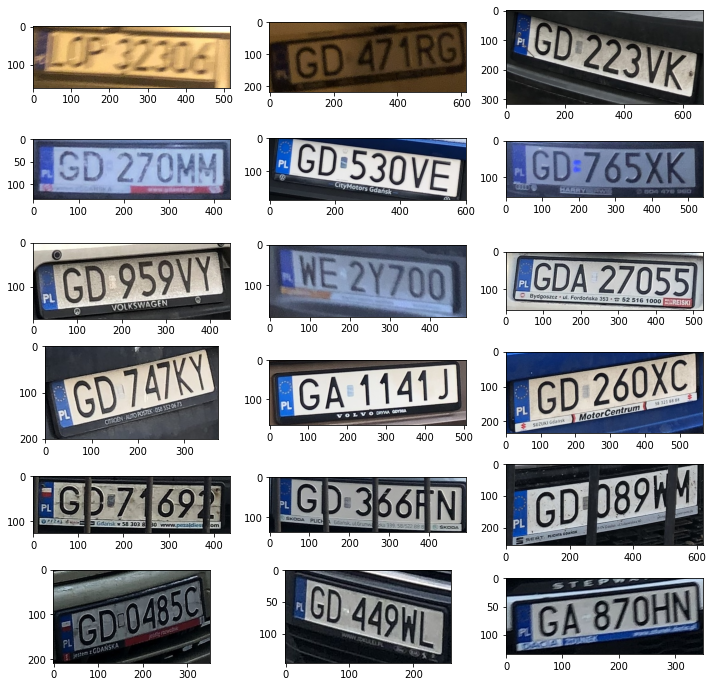

In [3]:
import matplotlib.pyplot as plt 
n_row = 6
n_col = 3
_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(image_list, axs):
    ax.imshow(img)
plt.show()

Jak widać tablice prezentują sie dosyć różnorodnie, z uwagi na różny kontrast na zdj, ostrośc, rotacje samych tablic czy pojawiające się przesłony w postaci krat. Na niektórych zdjęciach widać rónież inne napisy niż same numery tablic, chociażby na paskach uchwytów tablic.

## Pierwszy przykład i zastosowane operacje

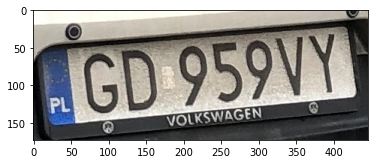

In [63]:
example = image_list[6]
plt.imshow(example)

In [52]:
ocr = OCR()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [64]:
ocr_label = ocr.run_easy_ocr(example)
print(ocr_label)

_____vvvvv_____
[([[18, 112], [54, 112], [54, 144], [18, 144]], 'PL', 0.9942077109604293), ([[55, 14], [426, 14], [426, 151], [55, 151]], 'CD 9591X', 0.30566965750656044), ([[171, 121], [310, 121], [310, 162], [171, 162]], 'VOLKSWAGEN', 0.5785538530418881)]
_____^^^^^_____
CD 9591X


Wykorzystanie OCR na nieprzetworzonymn obrazie daje błędny wynik, w postaci różnyc 3 znaków względem prawdziwej rejestracji.

Best angle: -5


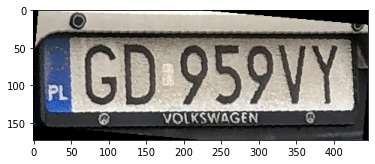

In [65]:
example = ocr.preprocessor.rotate_img(example)
plt.imshow(example)

In [66]:
ocr_label = ocr.run_easy_ocr(example)
print(ocr_label)

_____vvvvv_____
[([[16, 96], [50, 96], [50, 126], [16, 126]], 'PL', 0.9984285373259408), ([[57, 30], [419, 30], [419, 139], [57, 139]], 'GD 959VY', 0.39581339309185987), ([[168, 130], [304, 130], [304, 156], [168, 156]], 'VOLKSWAGFN', 0.8279936878547252)]
_____^^^^^_____
GD 959VY


Wykorzystana metoda rotacji tablicy pozwala już w pierwszym kroku uzyskać poprawną rejestracje.

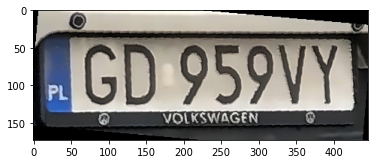

In [67]:
example = ocr.preprocessor.get_denoised_image(example)
plt.imshow(example)

In [68]:
ocr_label = ocr.run_easy_ocr(example)
print(ocr_label)

_____vvvvv_____
[([[16, 96], [52, 96], [52, 126], [16, 126]], 'PL', 0.9976946721070288), ([[58, 34], [420, 34], [420, 138], [58, 138]], 'GD 959VY', 0.4487665874305517), ([[168, 130], [304, 130], [304, 156], [168, 156]], 'VOLKSWAGFN', 0.8118506277973669)]
_____^^^^^_____
GD 959VY


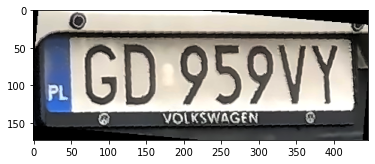

In [69]:
example, a, b = ocr.preprocessor.automatic_brightness_and_contrast(example)
plt.imshow(example)

In [70]:
ocr_label = ocr.run_easy_ocr(example)
print(ocr_label)

_____vvvvv_____
[([[16, 96], [52, 96], [52, 126], [16, 126]], 'PL', 0.9967675203653084), ([[58, 34], [420, 34], [420, 138], [58, 138]], 'GD 959vY', 0.41465918586227923), ([[168, 130], [304, 130], [304, 156], [168, 156]], 'VOLKSWAGFN', 0.7846563501268319)]
_____^^^^^_____
GD 959vY


Kolejne metody nie spowodowały utraty jakości odczytanych znaków, zastosowano filtracje szumów i dostosowanie kontrastu.

## Przykład drugi, przypadek nocny

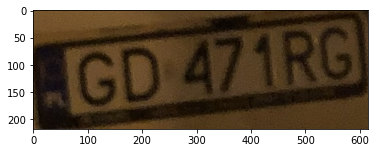

In [71]:
example2 = image_list[1]
plt.imshow(example2)

In [72]:
ocr_label2 = ocr.run_easy_ocr(example2)
print(ocr_label2)

_____vvvvv_____
[([[60, 11], [615, 11], [615, 197], [60, 197]], '[DZIZRC', 0.33018388127028697)]
_____^^^^^_____
[DZIZRC


Uzyskany wynik jest daleki od prawdziwego.

Best angle: -1


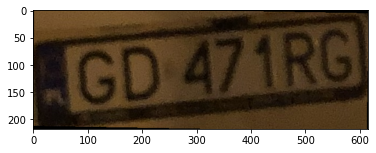

In [73]:
example2 = ocr.preprocessor.rotate_img(example2)
plt.imshow(example2)

In [74]:
ocr_label2 = ocr.run_easy_ocr(example2)
print(ocr_label2)

_____vvvvv_____
[([[61, 13], [613, 13], [613, 193], [61, 193]], 'CDZZRd', 0.4055395073478798)]
_____^^^^^_____
CDZZRd


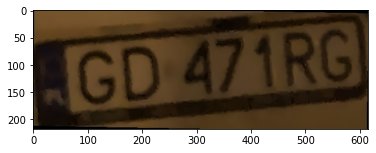

In [75]:
example2 = ocr.preprocessor.get_denoised_image(example2)
plt.imshow(example2)

In [76]:
ocr_label2 = ocr.run_easy_ocr(example2)
print(ocr_label2)

_____vvvvv_____
[([[60, 13], [613, 13], [613, 194], [60, 194]], 'GD ZZRd', 0.19744739371442965)]
_____^^^^^_____
GD ZZRd


Zastosowanie rotacji, spowodowało zmiane predykcji, ale wynik nie poprawił się, dopiero odszumianie pozwoliło na predykcje zawierającą poprawne 2 pierwsze litery.

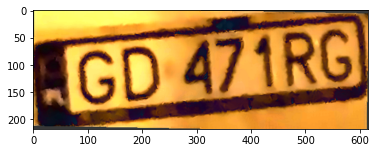

In [77]:
example2, a2, b2 = ocr.preprocessor.automatic_brightness_and_contrast(example2)
plt.imshow(example2)

In [78]:
ocr_label2 = ocr.run_easy_ocr(example2)
print(ocr_label2)

_____vvvvv_____
[([[62, 13], [613, 13], [613, 196], [62, 196]], 'CDZZRG', 0.7112484007596266)]
_____^^^^^_____
CDZZRG


Zastosowanie zmiany kontrastu pogorszyło wynik

_____vvvvv_____
[([[55, 12], [612, 12], [612, 195], [55, 195]], '@DZZRG', 0.3505556778800894)]
_____^^^^^_____
@DZZRG


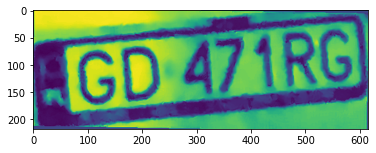

In [79]:
example2 = cv2.cvtColor(example2, cv2.COLOR_RGB2GRAY)
plt.imshow(example2)

ocr_label2 = ocr.run_easy_ocr(example2)
print(ocr_label2)

_____vvvvv_____
[([[276, 39], [535, 39], [535, 154], [276, 154]], '47 AR', 0.17229329060566895)]
_____^^^^^_____
47 AR


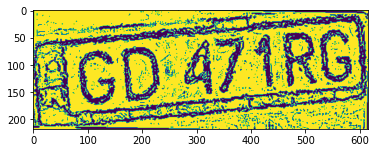

In [80]:
example2 = cv2.adaptiveThreshold(example2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(example2)

ocr_label2 = ocr.run_easy_ocr(example2)
print(ocr_label2)

_____vvvvv_____
[([[54, 11], [608, 11], [608, 194], [54, 194]], 'ID 4ZTRG', 0.10895133551053206)]
_____^^^^^_____
ID 4ZTRG


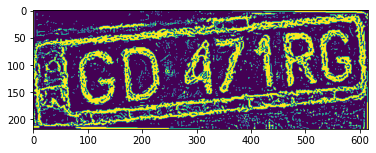

In [81]:
example2 = cv2.bitwise_not(example2)
plt.imshow(example2)

ocr_label2 = ocr.run_easy_ocr(example2)
print(ocr_label2)

Na tablicy zastosowano szereg operacji dających w wyniku obraz binarny. Wynik wciąż jest daleki od referencyjnego, utracono informacje o pierwszym znaku natomiast uzyskano liczbe znaków pokrywającyhc się z liczbą znaków na tablicy.

_____vvvvv_____
[([[64, 15], [613, 15], [613, 195], [64, 195]], 'CD 4ZIRG', 0.24523260990586018)]
_____^^^^^_____
CD 4ZIRG


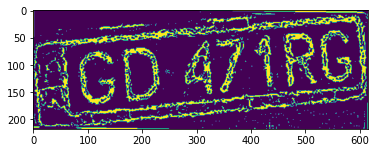

In [82]:
kernel = np.ones((2,2),np.uint8)
er = cv2.erode(example2 ,kernel,iterations = 1)

plt.imshow(er)

ocr_label2 = ocr.run_easy_ocr(er)
print(ocr_label2)

_____vvvvv_____
[([[251, 14], [613, 14], [613, 175], [251, 175]], 'AZ1RG', 0.267315789837362), ([[68.26748712738153, 66.1003892954812], [244.59223848916236, 52.48054587644947], [246.73251287261846, 181.8996107045188], [70.40776151083766, 195.51945412355053]], 'GD', 0.9960602821798435)]
_____^^^^^_____
AZ1RG


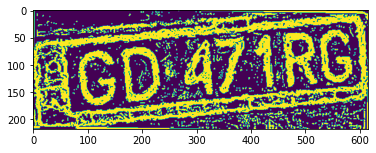

In [83]:
di = cv2.dilate(example2, kernel, iterations=1)
plt.imshow(di)

ocr_label2 = ocr.run_easy_ocr(di)
print(ocr_label2)

_____vvvvv_____
[([[5, 65], [237, 65], [237, 179], [5, 179]], 'BGD', 0.21773350308676265), ([[262, 20], [610, 20], [610, 172], [262, 172]], '471RG', 0.7189503188675741)]
_____^^^^^_____
471RG


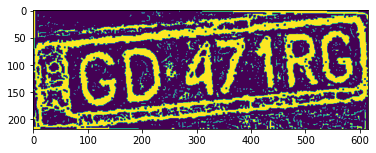

In [85]:
di = cv2.dilate(example2, kernel, iterations=2)
erdi = cv2.erode(di ,kernel,iterations=2)
plt.imshow(erdi)

ocr_label2 = ocr.run_easy_ocr(erdi)
print(ocr_label2)

Podjęto się eksperymentu przperowadzenie operacji dylacji i erozji, pojedyńczo operacje nie dawały pożądanych efektów, wręcz oddalały od wzorcowego rozwiązania. Natomiast zostosowanie podwójnej operacji dylacji a następnie podwójnej operacji erozji pozwoliło uzyskać wynik pokrywający się w dużej mierzę z prawdą. W dwóch słowach uzyskano BGD i 471RG co przy połączeniu daje informacje o tablicy z różnicą jednego znaku.

## Przykład trzeci, zbyt wiele operacji.

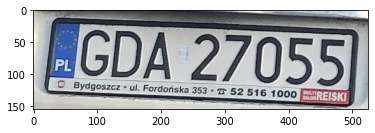

In [90]:
example3 = image_list[8]
plt.imshow(example3)

In [91]:
ocr_label3 = ocr.run_easy_ocr(example3)
print(ocr_label3)

_____vvvvv_____
[([[30, 72], [66, 72], [66, 102], [30, 102]], 'PL', 0.9993922122631974), ([[63, 18], [507, 18], [507, 135], [63, 135]], 'GDA27055', 0.7512285438740213), ([[63, 111], [141, 111], [141, 129], [63, 129]], 'Bydgoszcz', 0.9997995196629783), ([[170, 114], [277, 114], [277, 135], [170, 135]], 'Fordonska 353', 0.972982175828431), ([[304, 116], [418, 116], [418, 142], [304, 142]], '52 516 1000', 0.8872755581044381), ([[418, 122], [498, 122], [498, 146], [418, 146]], 'Ereiski]', 0.46548954845667717)]
_____^^^^^_____
GDA27055


Best angle: 2


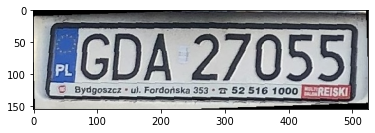

In [92]:
example3 = ocr.preprocessor.rotate_img(example3)
plt.imshow(example3)

In [93]:
ocr_label3 = ocr.run_easy_ocr(example3)
print(ocr_label3)

_____vvvvv_____
[([[30, 80], [68, 80], [68, 110], [30, 110]], 'PL', 0.9319543364893166), ([[66, 22], [504, 22], [504, 123], [66, 123]], 'GDA 27055', 0.720769599649342), ([[65, 117], [143, 117], [143, 135], [65, 135]], 'Byagoszcz', 0.42741185743469234), ([[172, 116], [277, 116], [277, 136], [172, 136]], 'Fordonska 353', 0.9956325729849006), ([[288, 114], [500, 114], [500, 138], [288, 138]], '352 516 100o EREISKI]', 0.2876093739318464)]
_____^^^^^_____
GDA 27055


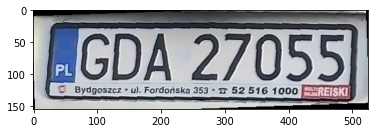

In [94]:
example3 = ocr.preprocessor.get_denoised_image(example3)
plt.imshow(example3)

In [95]:
ocr_label3 = ocr.run_easy_ocr(example3)
print(ocr_label3)

_____vvvvv_____
[([[30, 80], [68, 80], [68, 110], [30, 110]], 'PL', 0.9124766288898956), ([[66, 22], [502, 22], [502, 123], [66, 123]], 'GDA 27055', 0.9402286145137191), ([[63, 117], [143, 117], [143, 135], [63, 135]], 'Byagoszcz', 0.588002381231284), ([[172, 116], [279, 116], [279, 136], [172, 136]], 'Fordonska 353', 0.9826764807988437), ([[288, 114], [500, 114], [500, 138], [288, 138]], '3 52 516 1000 EREISKI]', 0.3619753445923172)]
_____^^^^^_____
GDA 27055


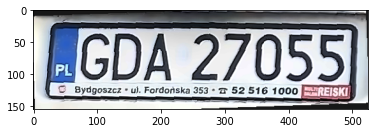

In [96]:
example3, a3, b3 = ocr.preprocessor.automatic_brightness_and_contrast(example3)
plt.imshow(example3)

In [97]:
ocr_label3 = ocr.run_easy_ocr(example3)
print(ocr_label3)

_____vvvvv_____
[([[30, 80], [68, 80], [68, 110], [30, 110]], 'PL', 0.9952066059302829), ([[65, 22], [502, 22], [502, 124], [65, 124]], 'GDA 27055', 0.8106219172803019), ([[63, 117], [143, 117], [143, 135], [63, 135]], 'Byagoszcz', 0.566700388656783), ([[172, 116], [277, 116], [277, 136], [172, 136]], 'Fordonska 353', 0.9976197237337536), ([[290, 114], [500, 114], [500, 140], [290, 140]], '3 52 516 10oo EREISKI]', 0.230297684889538)]
_____^^^^^_____
GDA 27055


In [98]:
example3 = cv2.cvtColor(example3, cv2.COLOR_RGB2GRAY)
ocr_label3 = ocr.run_easy_ocr(example3)
print("After img gray: ", ocr_label3)

example3 = cv2.adaptiveThreshold(example3, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
ocr_label3 = ocr.run_easy_ocr(example3)
print("After adaptiveThreshold: ", ocr_label3)

example3 = cv2.bitwise_not(example3)
ocr_label3 = ocr.run_easy_ocr(example3)
print("After bitwise_not: ", ocr_label3)

_____vvvvv_____
[([[32, 80], [68, 80], [68, 110], [32, 110]], 'PL', 0.9988407371040579), ([[66, 22], [504, 22], [504, 124], [66, 124]], 'GDA 27055', 0.682580978915311), ([[63, 117], [143, 117], [143, 135], [63, 135]], 'Byagoszcz', 0.5909585106771142), ([[172, 116], [279, 116], [279, 136], [172, 136]], 'Fordonska 353', 0.9887431011696771), ([[288, 114], [498, 114], [498, 138], [288, 138]], '3 52 516 1000 EREISKI', 0.38805457969978296)]
_____^^^^^_____
After img gray:  GDA 27055
_____vvvvv_____
[([[64, 22], [504, 22], [504, 124], [64, 124]], 'GDA 27055', 0.4446603017634414), ([[65, 117], [143, 117], [143, 135], [65, 135]], '8ybgo5z2r', 0.05059414861516901), ([[150, 114], [498, 114], [498, 140], [150, 140]], '@Fordonska 35322*52 516 40oEnEISK]', 0.06819166656337516)]
_____^^^^^_____
After adaptiveThreshold:  GDA 27055
_____vvvvv_____
[([[64, 22], [504, 22], [504, 123], [64, 123]], '[DA27055', 0.5741348819368312), ([[63, 117], [143, 117], [143, 135], [63, 135]], 'Bypgoszcz', 0.475714539014

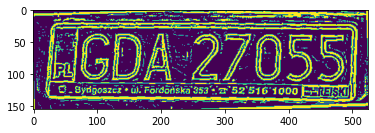

In [99]:
plt.imshow(example3)

Jak można zaobserwować na powyżsyzm przykładzie, w niektóych pryzpadkach nadmiar operacji w przetwarzaniu wstępnym powoduje utrate dobrego wyniku. Przykład reprezentuje jedno z lepszej jakości zdjęć w bazie, co pozwala na wykrycie i odczytanie nie tylko samych numeró ale również paska pod rejestracją, mimo to po serii operacji zaczęły pojawiać się błędy w odczycie pierwszego znaku tablicy.